In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
from torch.utils.data import DataLoader

import hydra

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from src.models.core_models.zero_shot_ris.freesolo import CustomFreeSOLOs
from src.data.core_datasets.zeroshot_dataset import ZeroShotDataset

/mnt/Enterprise2/rabin/ml-scratchpad/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with hydra.initialize(version_base="1.3", config_path="../configs/model"):
    cfg = hydra.compose(config_name="zsseg.yaml")
cfg

{'_target_': 'src.models.image_text_mask_module.ImageTextMaskModule', 'net': {'_target_': 'src.models.core_models.zero_shot_ris.ZeroShotRIS', 'clip_pretrained_path': '${model_pretrained_path}', 'is_hf_model': '${is_hf_model}', 'solo_state_dict_path': '${paths.pretrain_dir}/FreeSOLO_R101_30k.pt', 'solo_config': {'CUDNN_BENCHMARK': False, 'DATALOADER': {'ASPECT_RATIO_GROUPING': True, 'FILTER_EMPTY_ANNOTATIONS': True, 'NUM_WORKERS': 4, 'REPEAT_THRESHOLD': 0.0, 'SAMPLER_TRAIN': 'TrainingSampler'}, 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000, 'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000, 'PROPOSAL_FILES_TEST': [], 'PROPOSAL_FILES_TRAIN': [], 'TEST': ['coco_2017_val'], 'TRAIN': ['coco_2017_train_unlabeled_densecl_r101']}, 'GLOBAL': {'HACK': 1.0}, 'INPUT': {'CROP': {'ENABLED': False, 'SIZE': [0.9, 0.9], 'TYPE': 'relative_range'}, 'FORMAT': 'RGB', 'MASK_FORMAT': 'bitmask', 'MAX_SIZE_TEST': 1333, 'MAX_SIZE_TRAIN': 1333, 'MIN_SIZE_TEST': 800, 'MIN_SIZE_TRAIN': [640, 672, 704, 736, 768, 800], 

In [4]:
pretrained_path = "openai/clip-vit-base-patch32"
# pretrained_path = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"

In [5]:
# img_size = 224
img_mean= [0.48145466, 0.4578275, 0.40821073]
img_std= [0.26862954, 0.26130258, 0.27577711] 

In [6]:
transforms = A.Compose([    
    # A.Resize(height=img_size, width=img_size, interpolation=cv2.INTER_CUBIC),
    A.Normalize(mean=0,std=1),
    ToTensorV2(transpose_mask=True)
])

In [7]:
ds= ZeroShotDataset(
  images_dir="../data/kvasir_polyp/images",
  masks_dir="../data/kvasir_polyp/masks",
  caps_file="../data/kvasir_polyp/anns/test.json",
  tokenizer_pretrained_path=pretrained_path,
  prompt_type="p3",
  object_class="polyp",
  transforms= transforms,
  return_tensors= "pt",
)

In [8]:
dl = DataLoader(ds)

In [9]:
sample = next(iter(dl))
sample

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'mask': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
      

In [10]:
sample["image"].shape

torch.Size([1, 3, 529, 621])

In [11]:
sample["input_ids"].shape

torch.Size([1, 2, 6])

In [12]:
image_input = sample["image"]

In [13]:
solo = CustomFreeSOLO(cfg.net.solo_config, "../pretrain/FreeSOLO_R101_30k.pt")

In [15]:
from monai.metrics import MeanIoU, compute_iou, DiceHelper

iou_helper = MeanIoU(reduction="mean_channel")
dice_helper = DiceHelper(reduction="mean_channel")

In [16]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
device

'cuda:1'

In [17]:
solo.to(device)
solo.eval();

CustomFreeSOLO(
  (model): PseudoSOLOv2(
    (backbone): FPN(
      (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (top_block): LastLevelMaxPool()
      (bottom_up): ResNet(
        (stem): BasicStem(
          (conv1): Conv2d(
            3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
      

In [75]:
max_dices = []
max_ious = []

with torch.inference_mode():
    for i, batch in enumerate(dl, 1):
        image_input = batch["image"].to(device)
        mask = batch["mask"].to(device)
        
        pred_boxes, pred_masks = solo(image_input[0])

        print(f"{i}/{len(dl)}: Num Masks Predicted", pred_masks.size(0))

        pred_with_channel = pred_masks.unsqueeze(1)
        expanded_mask = mask.expand(pred_with_channel.size(0), -1, -1, -1)
        
        f, non_nans = dice_helper(pred_with_channel, expanded_mask)
        dice = f.max().item()
        
        g = iou_helper(pred_with_channel, expanded_mask)
        iou = g.max().item()
        
        max_dices.append(dice)
        max_ious.append(iou)

0/100: Num Masks Predicted 49
1/100: Num Masks Predicted 68
2/100: Num Masks Predicted 47
3/100: Num Masks Predicted 52
4/100: Num Masks Predicted 30
5/100: Num Masks Predicted 57
6/100: Num Masks Predicted 58
7/100: Num Masks Predicted 58
8/100: Num Masks Predicted 81
9/100: Num Masks Predicted 49
10/100: Num Masks Predicted 55
11/100: Num Masks Predicted 36
12/100: Num Masks Predicted 62
13/100: Num Masks Predicted 82
14/100: Num Masks Predicted 51
15/100: Num Masks Predicted 61
16/100: Num Masks Predicted 23
17/100: Num Masks Predicted 47
18/100: Num Masks Predicted 39
19/100: Num Masks Predicted 65
20/100: Num Masks Predicted 74
21/100: Num Masks Predicted 50
22/100: Num Masks Predicted 53
23/100: Num Masks Predicted 30
24/100: Num Masks Predicted 62
25/100: Num Masks Predicted 58
26/100: Num Masks Predicted 47
27/100: Num Masks Predicted 45
28/100: Num Masks Predicted 64
29/100: Num Masks Predicted 64
30/100: Num Masks Predicted 65
31/100: Num Masks Predicted 45
32/100: Num Masks 

In [33]:
len(f), f.argmax()

(67, tensor(33, device='cuda:1'))

In [38]:
np_image = image_input[0].cpu().movedim(0, -1).numpy()
last_mask = mask.squeeze().cpu().numpy()
best_pred = pred_masks[f.argmax()].cpu().numpy()

In [24]:
def mean(x):
    return sum(x) / len(x)

In [25]:
mean(max_dices), mean(max_ious)

(0.709747532941401, 0.5919894470274448)

In [21]:
from matplotlib import pyplot as plt

import numpy as np

In [22]:
def rescale_img(img):
    img_min = img.min((0, 1))
    return (img - img_min) / (img.max((0, 1)) - img_min)

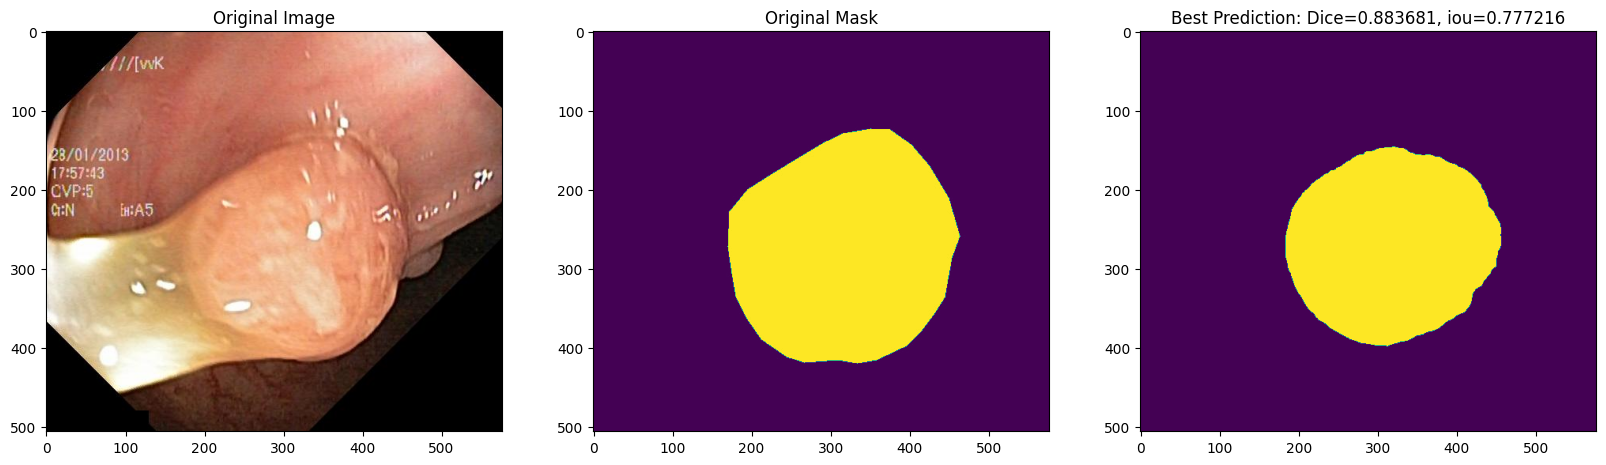

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.imshow(rescale_img(np_image))
ax1.set_title("Original Image")

ax2.imshow(last_mask)
ax2.set_title("Original Mask")

ax3.imshow(best_pred)
ax3.set_title(f"Best Prediction: Dice={dice:4f}, iou={iou:4f}");

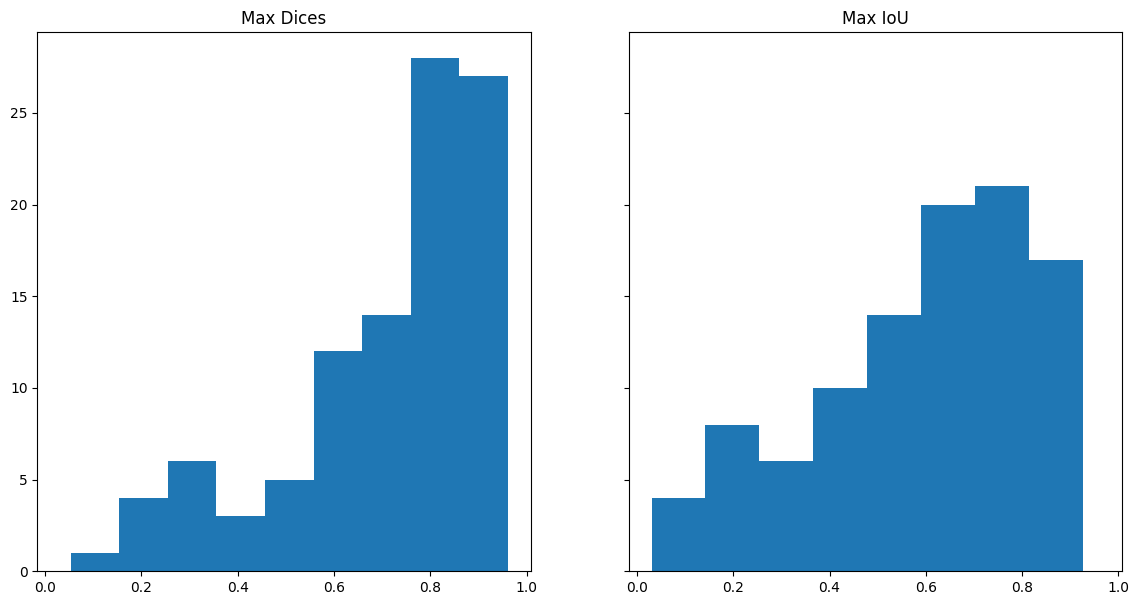

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 7))

ax1.hist(max_dices, bins="auto")
ax1.set_title("Max Dices")

ax2.hist(max_ious, bins="auto")
ax2.set_title("Max IoU");

In [ ]:
last_dices = f.cpu().numpy()
last_i

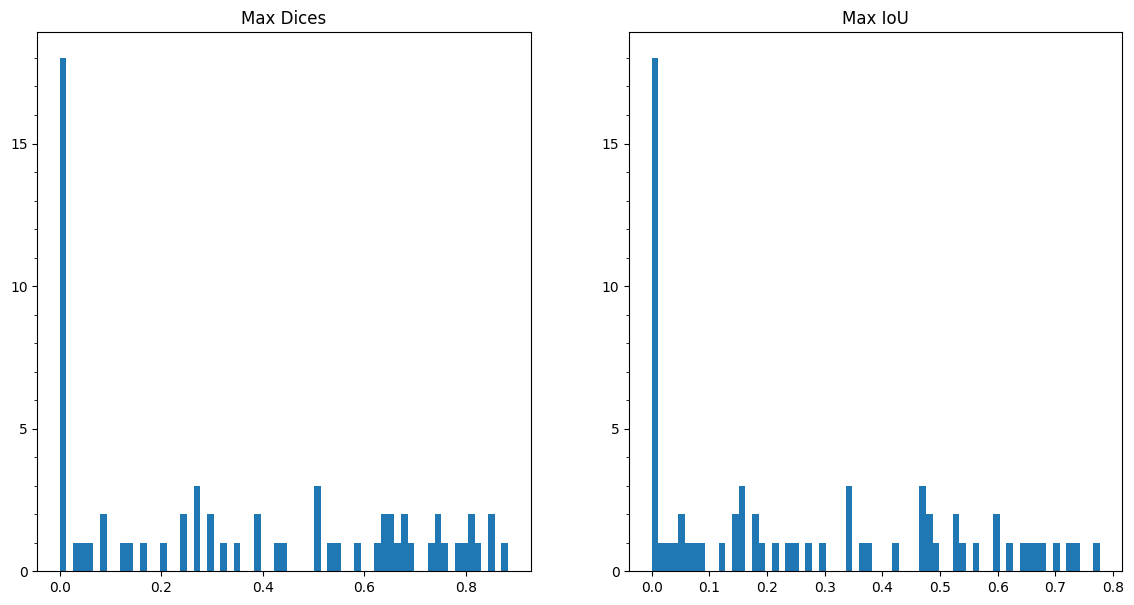

In [98]:
from matplotlib.ticker import MultipleLocator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

autolocator = AutoMinorLocator()

ax1.hist(f.cpu().numpy(), bins=len(f))
ax1.yaxis.get_major_locator().set_params(integer=True)
ax1.yaxis.set_minor_locator(autolocator)
ax1.set_title("Max Dices")

ax2.hist(g.cpu().numpy(), bins=len(g))
ax2.yaxis.get_major_locator().set_params(integer=True)
ax2.yaxis.set_minor_locator(autolocator)
ax2.set_title("Max IoU");